In [1]:
import pickle

with open('../../PNC_Good/MegaMeta3.pkl', 'rb') as f: 
    meta = pickle.load(f)
    
print('Complete')

Complete


In [4]:
with open('../../Work/LatentSim/Splits.pkl', 'rb') as f:
    keys, groups = pickle.load(f)
    
print(len(keys))
print(len(groups[0][0])+len(groups[0][1]))
print('Complete')

620
620
Complete


In [5]:
import numpy as np

nback = np.stack([meta[key]['nback'] for key in keys])
emoid = np.stack([meta[key]['emoid'] for key in keys])

print(nback.shape)
print(emoid.shape)

(620, 264, 231)
(620, 264, 210)


In [13]:
from nilearn.connectome import ConnectivityMeasure

def getFC(timeSeries, kind='correlation', transpose=True):
    connMeasure = ConnectivityMeasure(kind=kind)
    if transpose:
        timeSeries = np.transpose(timeSeries, axes=(0,2,1))
    return connMeasure.fit_transform(timeSeries)

nback_p = getFC(nback)
emoid_p = getFC(emoid)

print(nback_p.shape)

(620, 264, 264)


In [14]:
import torch

def convertTorch(p):
    t = torch.from_numpy(p).float()
    u = []
    for i in range(t.shape[0]):
        u.append(t[i][torch.triu_indices(264,264,offset=1).unbind()])
    return torch.stack(u).cuda()

nback_p_t = convertTorch(nback_p)
emoid_p_t = convertTorch(emoid_p)

print(nback_p_t.shape)
print(emoid_p_t.shape)
print('Complete')

torch.Size([620, 34716])
torch.Size([620, 34716])
Complete


In [22]:
age = np.stack([meta[key]['AgeInMonths'] for key in keys])
gen = np.stack([np.array([meta[key]['Gender'] == 'M', meta[key]['Gender'] == 'F']) for key in keys]).astype(int)
wrt = np.stack([meta[key]['wratStd'] for key in keys])

print(age.shape)
print(gen.shape)
print(wrt.shape)

(620,)
(620, 2)
(620,)


In [25]:
age_t = torch.from_numpy(age).float().cuda()
gen_t = torch.from_numpy(gen).float().cuda()
wrt_t = torch.from_numpy(wrt).float().cuda()

print('Complete')

Complete


In [288]:
ageG_t = torch.zeros(age_t.numel(), 3).float().cuda()
borders = 12*np.array([8,14,18,24])

for j in range(age_t.numel()):
    for i in range(3):
        if age_t[j] >= borders[i] and age_t[j] < borders[i+1]:
            ageG_t[j,i] = 1
            break

print('Complete')

Complete


In [290]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn.dense import DenseGCNConv

def arith(n):
    return int(n*(n+1)/2)

class GCN(nn.Module):
    def __init__(self, nTgt, dp=0.5):
        super(GCN, self).__init__()
        self.gcn = []
        for i in range(2*nTgt):
            self.gcn.append(DenseGCNConv(arith(263),40).float().cuda())
            self.gcn.append(DenseGCNConv(40,3).float().cuda())
        self.gcn = nn.ModuleList(self.gcn)
        self.dp = nn.Dropout(p=dp)
        
    def forward(self, x):
        e = torch.ones(x.shape[0], x.shape[0]).float().cuda()/x.shape[0]
        x = self.dp(x)
        res = []
        for i in range(x.shape[1]):
            y = F.relu(self.gcn[2*i](x[:,i,:],e)).squeeze()
            y = self.gcn[2*i+1](y,e).squeeze()
            res.append(y)
        return res
    
def validate(model, X, y, testIdcs):
    model.eval()
    with torch.no_grad():
        res = model(X)
        avg = torch.mean(torch.stack(res), dim=0)
        if res[0].dim() == 1:
            loss = mseLoss(avg[testIdcs], y[testIdcs]).cpu().numpy()**0.5
        else:
            corr = (torch.argmax(avg, dim=1) == torch.argmax(y, dim=1))[testIdcs]
            loss = torch.sum(corr)/len(testIdcs)
    model.train()
    return loss
    
ceLoss = torch.nn.CrossEntropyLoss()
mseLoss = torch.nn.MSELoss()
nEpochs = 20000
pPeriod = 500
thresh = 0.02

para = [nback_p_t, emoid_p_t]
rmse = []

X = torch.stack(para, dim=1)

for i in range(10):
    gcn0 = GCN(2, 0)
    params = list(gcn0.parameters())
    optim = torch.optim.Adam(params, lr=1e-4, weight_decay=1e-4)

    trainIdcs = groups[i][0][0:496]
    validIdcs = groups[i][0]
    testIdcs = groups[i][1]
    
    Xt = X[trainIdcs]
    Xv = X[validIdcs]
    
    trainLoss = []
    validLoss = []
    
    for epoch in range(nEpochs):
        optim.zero_grad()
        res = gcn0(Xt)
        avg = torch.mean(torch.stack(res), dim=0)
        loss0 = 0
        loss1 = 0
        for r in res + [avg]:
            loss0 += ceLoss(r, ageG_t[trainIdcs])/(len(res)+1)
#         for param in params:
#             loss1 += 1e0*torch.sum(torch.abs(param))/torch.numel(param)/len(params)
        loss = torch.stack([loss0])
        torch.sum(loss).backward()
        optim.step()
        if epoch % pPeriod == 0 or epoch == nEpochs-1 or torch.all(loss[0:3] < thresh):
            print(f'epoch {epoch} loss={(float(loss0), float(loss1))}')
            lossV = validate(gcn0, Xv, ageG_t[validIdcs], np.arange(496,len(validIdcs)))
            if len(validLoss) == 0 or lossV > max(validLoss):
                print(f'New best validation epoch {epoch} loss={lossV}')
                torch.save(gcn0.state_dict(), '../../Work/LatentSim/gcn.pyt')
            validLoss.append(lossV)
            if torch.all(loss[0:3] < thresh):
                print('Early stopping')
                break
            
    print('Finished training')
    
    gcn0.load_state_dict(torch.load('../../Work/LatentSim/gcn.pyt'))
    loss0 = validate(gcn0, X, ageG_t, testIdcs)

    rmse.append((float(loss0)))
        
    print(i, end=' ')
    print(rmse[-1])

epoch 0 loss=(1.1408963203430176, 0.0)
New best validation epoch 0 loss=0.19354838132858276
epoch 500 loss=(0.7494196891784668, 0.0)
New best validation epoch 500 loss=0.5161290168762207
epoch 1000 loss=(0.5674991011619568, 0.0)
New best validation epoch 1000 loss=0.596774160861969
epoch 1500 loss=(0.35733160376548767, 0.0)
New best validation epoch 1500 loss=0.6129032373428345
epoch 2000 loss=(0.16693222522735596, 0.0)
New best validation epoch 2000 loss=0.6612902879714966
epoch 2500 loss=(0.07765331119298935, 0.0)
New best validation epoch 2500 loss=0.6935483813285828
epoch 3000 loss=(0.043530166149139404, 0.0)
epoch 3500 loss=(0.02377144806087017, 0.0)
New best validation epoch 3500 loss=0.7096773982048035
epoch 3707 loss=(0.019983122125267982, 0.0)
Early stopping
Finished training
0 0.6129032373428345
epoch 0 loss=(1.104051113128662, 0.0)
New best validation epoch 0 loss=0.5645161271095276
epoch 500 loss=(0.5304856300354004, 0.0)
New best validation epoch 500 loss=0.661290287971496

In [291]:
for a in rmse:
    print(a)

print('---')
print(sum(rmse)/len(rmse))

0.6129032373428345
0.6451612710952759
0.6129032373428345
0.6774193048477173
0.5645161271095276
0.6451612710952759
0.4677419066429138
0.5
0.6129032373428345
0.6129032373428345
---
0.5951612830162049


In [276]:
torch.sum(gcn0.gcn[0].lin.weight == 0)

tensor(0, device='cuda:0')

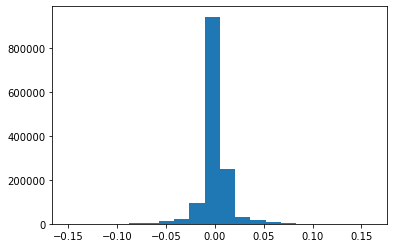

In [277]:
plt.hist(gcn0.gcn[0].lin.weight.flatten().detach().cpu().numpy(), bins=20)
plt.show()

In [326]:
def mask(e):
    return e - torch.diag(torch.diag(e.detach()))

class LatSim(nn.Module):
    def __init__(self, nTgts, dp=0.5, dp2=0.1, method='same'):
        super(LatSim, self).__init__()
        self.nTgts = nTgts
        self.method = method
        self.masks = []
        if method == 'same':
            nMasks = nTgts
        elif method == 'diff':
            nMasks = 2*nTgts
        elif method == 'univ':
            nMasks = nTgts+1
        for i in range(nMasks):
            self.masks.append(nn.Parameter(
                1e-4*torch.randn(arith(263),2).float().cuda()
            ))
        self.dp = nn.Dropout(p=dp)
        self.dp2 = nn.Dropout(p=dp2)
    
    def getLatentsAndEdges(self, x, i):
        if self.method == 'univ':
            y = torch.einsum('ac,ce->ae', x, self.masks[0])
            z = torch.einsum('ac,ce->ae', x, self.masks[i+1])
            e = y@z.T
            e = e+e.T
            return y, z, e
        elif self.method == 'diff':
            y = torch.einsum('ac,ce->ae', x, self.masks[2*i])
            z = torch.einsum('ac,ce->ae', x, self.masks[2*i+1])
            e = y@z.T
            e = e+e.T
            return y, z, e
        elif self.method == 'same':
            y = torch.einsum('ac,ce->ae', x, self.masks[i])
            e = y@y.T
            return y, y, e
        
    def forward(self, x, y, testIdcs=None):
        x = self.dp(x)
        res = []
        es = []
        for i in range(self.nTgts):
            nClass = y.shape[1] if y.dim() == 2 else 1
            _, _, e = self.getLatentsAndEdges(x[:,i,:], i)
            if testIdcs is not None:
                e[:,testIdcs] = 0
            e = self.dp2(e)
            e = mask(e)
            e[e == 0] = float('-inf')
            e = F.softmax(e, dim=1)
            es.append(e)
            res.append(e@y)
        return res, es

def validate(model, X, y, testIdcs):
    model.eval()
    with torch.no_grad():
        res, _ = model(X, y, testIdcs)
        avg = torch.mean(torch.stack(res), dim=0)
        if res[0].dim() == 1:
            loss = mseLoss(avg[testIdcs], y[testIdcs]).cpu().numpy()**0.5
        else:
            corr = (torch.argmax(avg, dim=1) == torch.argmax(y, dim=1))[testIdcs]
            loss = torch.sum(corr)/len(testIdcs)
    model.train()
    return loss
        
nEpochs = 5000
pPeriod = 200
thresh = 0.4

para = [nback_p_t, emoid_p_t]
rmse = []

X = torch.stack(para, dim=1)

for i in range(10):
    sim = LatSim(len(para), 0.5, 0.1, 'same')
    optim = torch.optim.Adam(sim.masks, lr=1e-4, weight_decay=1e-4)

    trainIdcs = groups[i][0][0:496]
    validIdcs = groups[i][0]
    testIdcs = groups[i][1]
    
    Xt = X[trainIdcs]
    Xv = X[validIdcs]
    
    trainLoss = []
    validLoss = []
    
    vIdcs1 = np.arange(496,len(validIdcs))
    vIdcs2 = validIdcs[496:]
    vIdcs3 = np.concatenate([testIdcs, vIdcs2])
    
    a = ageG_t[trainIdcs][:,0:1]
    b = ageG_t[trainIdcs][:,1:2]
    c = ageG_t[trainIdcs][:,2:3]
    eTgt = mask(a@a.T+b@b.T+c@c.T)
    eTgt[eTgt == 0] = float('-inf')
    eTgt = F.softmax(eTgt, dim=1)

    var = ageG_t
    
    for epoch in range(nEpochs):
        optim.zero_grad()
        res, es = sim(Xt, var[trainIdcs])
        avg = torch.mean(torch.stack(res), dim=0)
        avgE = torch.mean(torch.stack(es), dim=0)
        loss0 = 0
        loss1 = 0
        for r,e in zip(res + [avg], es + [avgE]):
            loss0 += ceLoss(r, var[trainIdcs])
            loss1 += torch.mean(-e*torch.log(eTgt+1e-10)-eTgt*torch.log(e+1e-10))/2
        loss0 = loss0/(len(res)+1)
        loss1 = loss1/(len(res)+1)
        loss = torch.stack([loss0, loss1])
        torch.sum(loss).backward()
        optim.step()
        if epoch % pPeriod == 0 or epoch == nEpochs-1 or torch.all(loss[0:3] < thresh):
            print(f'epoch {epoch} loss={(float(loss0), float(loss1))}')
            lossV = validate(sim, Xv, var[validIdcs], vIdcs1)
            if len(validLoss) == 0 or lossV > max(validLoss):
                print(f'New best validation epoch {epoch} loss={lossV}')
                torch.save(gcn0.state_dict(), '../../Work/LatentSim/sim.pyt')
            validLoss.append(lossV)
            if torch.all(loss[0:3] < thresh):
                print('Early stopping')
                break
            
    print('Finished training')
    
    gcn0.load_state_dict(torch.load('../../Work/LatentSim/sim.pyt'))
    loss0 = validate(sim, X, var, testIdcs)

    rmse.append((float(loss0)))
        
    print(i, end=' ')
    print(rmse[-1])

epoch 0 loss=(1.085463047027588, 0.024306640028953552)
New best validation epoch 0 loss=0.6129032373428345
epoch 200 loss=(0.649011492729187, 0.01974203810095787)
New best validation epoch 200 loss=0.6290322542190552
epoch 400 loss=(0.6049752235412598, 0.019479749724268913)
epoch 600 loss=(0.5905827879905701, 0.01884659193456173)
New best validation epoch 600 loss=0.6612902879714966
epoch 800 loss=(0.5765407085418701, 0.018870187923312187)
epoch 1000 loss=(0.5730249285697937, 0.018127691000699997)
epoch 1200 loss=(0.5659176111221313, 0.018516208976507187)
epoch 1400 loss=(0.5623539686203003, 0.018231306225061417)
New best validation epoch 1400 loss=0.6774193048477173
epoch 1600 loss=(0.5621769428253174, 0.01746424287557602)
epoch 1800 loss=(0.5601495504379272, 0.017218101769685745)
epoch 2000 loss=(0.5597512722015381, 0.017480088397860527)
epoch 2200 loss=(0.5573773384094238, 0.016922248527407646)
epoch 2400 loss=(0.5570908784866333, 0.016510890796780586)
epoch 2600 loss=(0.55617010593

epoch 3400 loss=(0.5540333986282349, 0.01601889729499817)
epoch 3600 loss=(0.5538336038589478, 0.01610667258501053)
epoch 3800 loss=(0.5548531413078308, 0.015283259563148022)
epoch 4000 loss=(0.5536460876464844, 0.015534764155745506)
epoch 4200 loss=(0.5538944005966187, 0.015045726671814919)
epoch 4400 loss=(0.553566575050354, 0.015209902077913284)
epoch 4600 loss=(0.5532373189926147, 0.014681681990623474)
epoch 4800 loss=(0.5529398918151855, 0.014576882123947144)
epoch 4999 loss=(0.5534428358078003, 0.01430873479694128)
Finished training
4 0.596774160861969
epoch 0 loss=(1.0887260437011719, 0.02437780424952507)
New best validation epoch 0 loss=0.596774160861969
epoch 200 loss=(0.6359610557556152, 0.01952078938484192)
New best validation epoch 200 loss=0.6451612710952759
epoch 400 loss=(0.5900949835777283, 0.019692732021212578)
epoch 600 loss=(0.5767766237258911, 0.019337015226483345)
epoch 800 loss=(0.573107898235321, 0.018062245100736618)
New best validation epoch 800 loss=0.69354838

epoch 1200 loss=(0.5652992725372314, 0.018297668546438217)
New best validation epoch 1200 loss=0.7258064150810242
epoch 1400 loss=(0.5610888004302979, 0.01810571923851967)
epoch 1600 loss=(0.559008002281189, 0.01806892640888691)
epoch 1800 loss=(0.5577824115753174, 0.017736509442329407)
epoch 2000 loss=(0.5584126710891724, 0.01749856024980545)
New best validation epoch 2000 loss=0.7419354915618896
epoch 2200 loss=(0.5588807463645935, 0.016783133149147034)
epoch 2400 loss=(0.5569382905960083, 0.017514510080218315)
epoch 2600 loss=(0.5559045672416687, 0.01653647981584072)
epoch 2800 loss=(0.5577976107597351, 0.016016047447919846)
epoch 3000 loss=(0.556027352809906, 0.01615794748067856)
epoch 3200 loss=(0.5556472539901733, 0.016800465062260628)
epoch 3400 loss=(0.5564371347427368, 0.016374196857213974)
epoch 3600 loss=(0.5554215312004089, 0.01532355323433876)
epoch 3800 loss=(0.5549440383911133, 0.015247300267219543)
epoch 4000 loss=(0.5538110733032227, 0.015249472111463547)
epoch 4200 lo

In [327]:
for a in rmse:
    print(a)

print('---')
print(sum(rmse)/len(rmse))

0.5483870506286621
0.6451612710952759
0.596774160861969
0.6774193048477173
0.596774160861969
0.6451612710952759
0.5483870506286621
0.5806451439857483
0.6129032373428345
0.6290322542190552
---
0.608064490556717


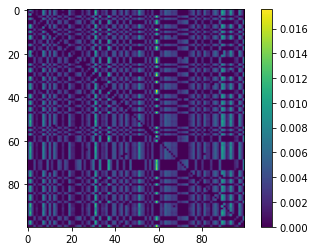

In [182]:
plt.imshow(e[0:100,0:100].detach().cpu().numpy())
plt.colorbar()
plt.show()

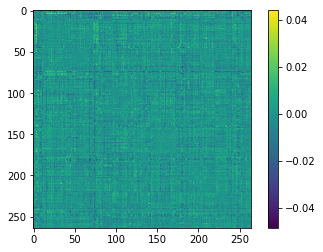

In [334]:
def heatmap(cudamask):
    iu = np.triu_indices(264, 1)
    m = np.zeros([264,264])
    v = cudamask.detach().cpu().numpy()
    m[iu] = v
    m = m + m.T
    return m

m0_0 = heatmap(sim.masks[0][:,1])
m0_1 = heatmap(sim.masks[0][:,2])

plt.imshow(m0_0)
plt.colorbar()
plt.show()

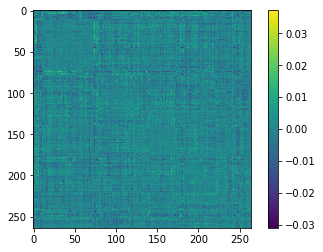

In [335]:
plt.imshow(m0_1)
plt.colorbar()
plt.show()

In [328]:
idcs = []
for i,a in enumerate(age):
    if a >= 14*12 and a >= 18*12:
        idcs.append(i)
idcs = np.array(idcs)
print(idcs)

[  3  10  27  32  36  44  48  55  56  58  60  61  71  72  76  80  82  85
  90  91 107 108 112 122 125 130 134 142 143 146 160 168 170 171 173 174
 178 179 180 191 192 195 197 200 210 211 215 217 220 232 237 240 242 249
 251 257 263 266 276 278 279 282 288 293 301 303 305 306 307 311 315 328
 334 336 337 349 350 353 363 372 373 380 385 393 407 410 412 413 417 418
 422 423 426 427 429 430 431 433 434 435 437 438 441 446 447 454 462 470
 474 476 479 480 487 492 500 501 502 503 520 521 524 526 529 539 546 548
 558 562 565 570 571 577 578 583 584 589 591 592 599 617]


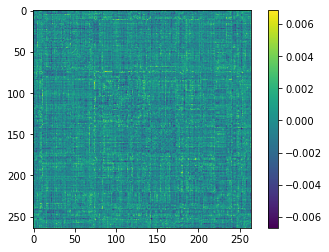

In [330]:
plt.imshow(m0_0*np.mean(nback_p[idcs], axis=0))
plt.colorbar()
plt.show()